In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from astroNN.nn.layers import MCDropout
import math
# np.random.seed(0)

### In this notebook, we use a compressed version of JLA compilation
#### First, we load the trained AutoEncoder

In [2]:
np.random.seed(0)

In [3]:
file2 = '../data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))

# shuffle = [x for x in range(len(data.values)) if x%2 == 0]
# comp = [x for x in range(len(data.values)) if x%2 ==1]
# shuffle.extend(comp)
shuffle = [0,1,2,3,4,5,6,7,8,30,28,26,24,22,20,9,10,12,14,16,18,29,27,25,23,21,19,17,15,13,11]

nsize = len(syscov)
# print(data.head(31))
# data.head(31) 
# plt.savefig("DistbinnedJLA.png")
np.shape(syscov)

errors = np.diag(syscov).reshape(nsize,1)
errors = np.where(errors!= 0, np.log(errors), 0)

z = data.values[:,0][shuffle]
dl = data.values[:,1][shuffle]

# FFNN

In [4]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]

# index = np.argsort(z)
zz = np.log10(z)

# scalerz = StandardScaler()
# scalerz.fit(z.reshape(-1, 1))
# zz = scalerz.transform(z.reshape((-1,1)))


scalerdl = StandardScaler()
scalerdl.fit(dl.reshape(-1, 1))
dll = scalerdl.transform(dl.reshape((-1,1)))
# dll = dl.reshape(nsize, 1)


# scalererr = StandardScaler()
# scalererr.fit(errors.reshape(-1, 1))
# errscl = scalererr.transform(errors.reshape((-1,1)))

z_train, z_test = np.split(zz, indx)
y = dll
y_train, y_test = np.split(y, indx)
# y


In [5]:
def model2_dropout(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.01)(efirst)
    x = Dense(100, activation='relu')(x)
    x = MCDropout(0.01)(x)
    x = Dense(150, activation='relu')(x)
    x = MCDropout(0.01)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
MCDropout_2 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               15150     
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 150)               0     

In [6]:
model2_train = neural_model2.fit(z_train, y_train, batch_size=4,
                                    epochs=1000,verbose=1,
                                    validation_data=(z_test, y_test))
#                                     callbacks=callbacks)

Epoch 1/1000
6/6 [==============================] - 0s 52ms/step - loss: 1.2813 - val_loss: 0.2441
Epoch 2/1000
6/6 [==============================] - 0s 4ms/step - loss: 1.0667 - val_loss: 0.3228
Epoch 3/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.7064 - val_loss: 0.4130
Epoch 4/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.8025 - val_loss: 0.4099
Epoch 5/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.7144 - val_loss: 0.3201
Epoch 6/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.6336 - val_loss: 0.2085
Epoch 7/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.2666 - val_loss: 0.0820
Epoch 8/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1831 - val_loss: 0.0174
Epoch 9/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0393 - val_loss: 0.0057
Epoch 10/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0198 - val_loss: 0.0219
Epoch 11/1000
6/6 

6/6 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.0027
Epoch 84/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 85/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 86/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0079 - val_loss: 0.0044
Epoch 87/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0070 - val_loss: 0.0045
Epoch 88/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 89/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0038
Epoch 90/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0010
Epoch 91/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 92/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0269 - val_loss: 0.0013
Epoch 93/1000
6/6 [=====

Epoch 165/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0027
Epoch 166/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 167/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 168/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0071 - val_loss: 0.0019
Epoch 169/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0014
Epoch 170/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 171/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 172/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 9.8758e-04
Epoch 173/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 174/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0

6/6 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 247/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0050
Epoch 248/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0170 - val_loss: 5.3741e-04
Epoch 249/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 7.4657e-04
Epoch 250/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 9.2701e-04
Epoch 251/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 252/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 253/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 5.1273e-04
Epoch 254/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 255/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0012

6/6 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 328/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 329/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0019
Epoch 330/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 331/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 332/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 7.9119e-04
Epoch 333/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 334/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 335/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0070 - val_loss: 0.0028
Epoch 336/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 9.4399e-04
Epoch 3

6/6 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 409/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 3.6295e-04
Epoch 410/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 411/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0053
Epoch 412/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 413/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0011
Epoch 414/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 7.9902e-04
Epoch 415/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 416/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 6.4244e-04
Epoch 417/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0023
Epo

6/6 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 490/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 6.1482e-04
Epoch 491/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0016
Epoch 492/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 493/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 494/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 495/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 496/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 9.6892e-04
Epoch 497/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 498/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 6.5715e-04
Epo

6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 571/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 9.6839e-04
Epoch 572/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.3801e-04
Epoch 573/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 9.5056e-04
Epoch 574/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 575/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 576/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0078
Epoch 577/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.0014
Epoch 578/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 6.5753e-04
Epoch 579/1000
6/6 [==============================] - ETA: 0s - loss: 0.003 - 0s 4ms/step - loss: 0

Epoch 651/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 652/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 653/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 5.6159e-04
Epoch 654/1000
6/6 [==============================] - 0s 4ms/step - loss: 8.8354e-04 - val_loss: 0.0013
Epoch 655/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 656/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 657/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 5.9922e-04
Epoch 658/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 659/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 660/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0043 - val_l

Epoch 732/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 733/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 9.5319e-04
Epoch 734/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 735/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 736/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 737/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 738/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 739/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 9.4249e-04
Epoch 740/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 741/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss:

6/6 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 6.5394e-04
Epoch 814/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 815/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 816/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 817/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 818/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 9.5688e-04
Epoch 819/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 820/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 821/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 5.0171e-04
Epoch 822/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0013
Epo

6/6 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 895/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 5.2604e-04
Epoch 896/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 6.5742e-04
Epoch 897/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 9.6458e-04
Epoch 898/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0010
Epoch 899/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 900/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 8.7862e-04
Epoch 901/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 902/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 903/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0012

Epoch 975/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 976/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 977/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 9.2989e-04
Epoch 978/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 979/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 8.9812e-04
Epoch 980/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 6.3554e-04
Epoch 981/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 982/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 5.9996e-04
Epoch 983/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 9.8512e-04
Epoch 984/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0019

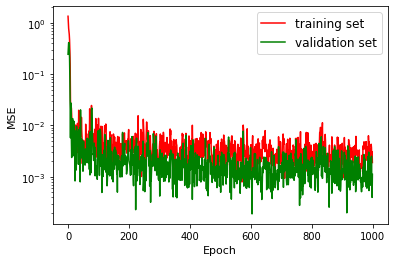

In [7]:
# plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.yscale('log')
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
# plt.xticks([])
# plt.yticks([])
# plt.title('FFNN+MC-DO', fontsize=8)

plt.savefig('loss_dropoutJLA2.png')

In [8]:
# file3 = 'fake_binned_JLA2TEST3new.dat'
# data3 = np.loadtxt(file3, skiprows=3)

# z_test = data3[:,0]
z_test = zz
# x_test = zz
# x_test

In [9]:
test_batch_size = 31
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
# x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 100# Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))

for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(z_test)
    

prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)

# get mean results and its varience
# pred_err = np.exp(pred_random[:,1].reshape(-1,1))
# pred_err = np.exp(pred_random[:,1].reshape(-1,1))


# sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)




In [10]:
# predictions_err

In [11]:
Om = 0.27
# variance network
w0 = -1

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
#     return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa):
#         if model == 'lcdm':
#             return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
#         elif model == 'owacdm':
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, w0=-1, wa=0.0):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, w0, wa)*(1+z))+43



In [12]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
    fowacdm1.append(distance_modulus(zzz, w0=-10, wa=-100))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

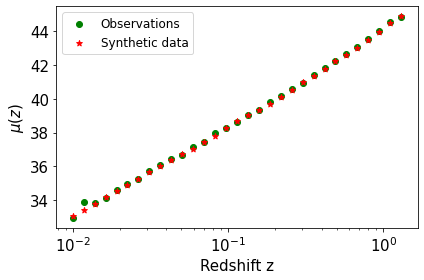

In [13]:
# Plotting
dlfake = scalerdl.inverse_transform(prediction_mc_dropout.reshape(-1,1))[:,0]
# dlfake = prediction_mc_dropout[:,0]
# plt.figure(figsize=(10, 7), dpi=100)

# fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
# sigma = np.sqrt(std_mc_dropout.reshape(31,))

plt.scatter(z, dl, c='g', label='Observations')
# plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.scatter(z, dlfake, marker='*', c='r', label='Synthetic data')

# plt.errorbar(x_test, dlfake, yerr=sigma
#              , markersize=10, fmt='.', 
#              ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='r',
#              label='Synthetic data')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# plt.plot(zmodel, fowacdm1, label='CPL $w_0 = -1.3, w_a=1.2$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
# plt.xlim(-0.01, np.max(z)+0.2)
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
# plt.xlim(0, np.max(z))
plt.xticks(fontsize=15)
# plt.text(0.6, 45, 'FFNN+MC-DO', fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')

plt.tight_layout()
plt.legend(loc='upper left', fontsize=12)
# plt.show()
plt.savefig('DL_dropoutb2.png')

In [14]:
index = np.argsort(z_test)
fake_data2 = np.stack((z[index], dlfake[index]), axis=1)


np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

In [15]:
tf.keras.models.save_model(neural_model2, '../models/FFNN_JLA_DO.h5' )